# Housing Prices Competition for Kaggle Learn Users

[Kaggle Page](https://www.kaggle.com/c/home-data-for-ml-course/overview)

We will be looking at a data set with 79 different features for the housing market in Amer, Iowa. **We want to build a model that is able to predict the value of a house given these features**

## Initial notes
This seems like a supervised, regression problem. We will be able to bring in the data in to memory as it is not that big, so we can also consider it a batch job.

The competition will also measure performance using root mean squared error (RMSE), so we will measure our model in here with the same metric. Specifically, it will take the mean of the logarithm of the the predicted value and the log of the actual value.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lets bring in the training data
# We already have two seperate data sets, one for training and one for testing
# The whole training data will be brought in and split into training and validation sets
val_train = pd.read_csv("data/train.csv")

# Peek at the data
val_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
val_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Listing out features with missing data**
1. LotFrontage - float64
2. Alley - object
3. MasVnrType - object 
4. MasVnrArea - float64
5. BsmtQual - object 
6. BsmtCond - object 
7. BsmtExposure - object 
8. BsmtFinType1 - object 
9. BsmtFinType2 - object 
10. Electrical - object
11. FireplaceQu - object
12. GarageYrBlt - float64
13. GarageFinish - object 
14. GarageQual - object
15. GarageCond - object 
16. PoolQC - object
17. Fence - object
18. MiscFeature - object

There are 3 numeric features that are missing records and 15 categorical ones that are missing.

**Other things of note**:
- MSSubClass is categorical. It describes the type of house and age. Im wondering how impactful this is ad this could technically be defined by a combination of other features.
- OverallQual and OverallCond are also categorical. 
- MasVnrType has a value for 'None', will propbably want to fill missing values with that value
- MasVnrArea should be zero if 'None' on Type
- BsmtExporsure also has NA value
- BsmtFinType have NA value as well
- FireplaceQu has NA values
- GarageType has NA value which may tie to missing values for Garage
    Qual and Cond have NA values as well though
- PoolQC has NA value
- Fence has NA value
- MiscFeture has NA value

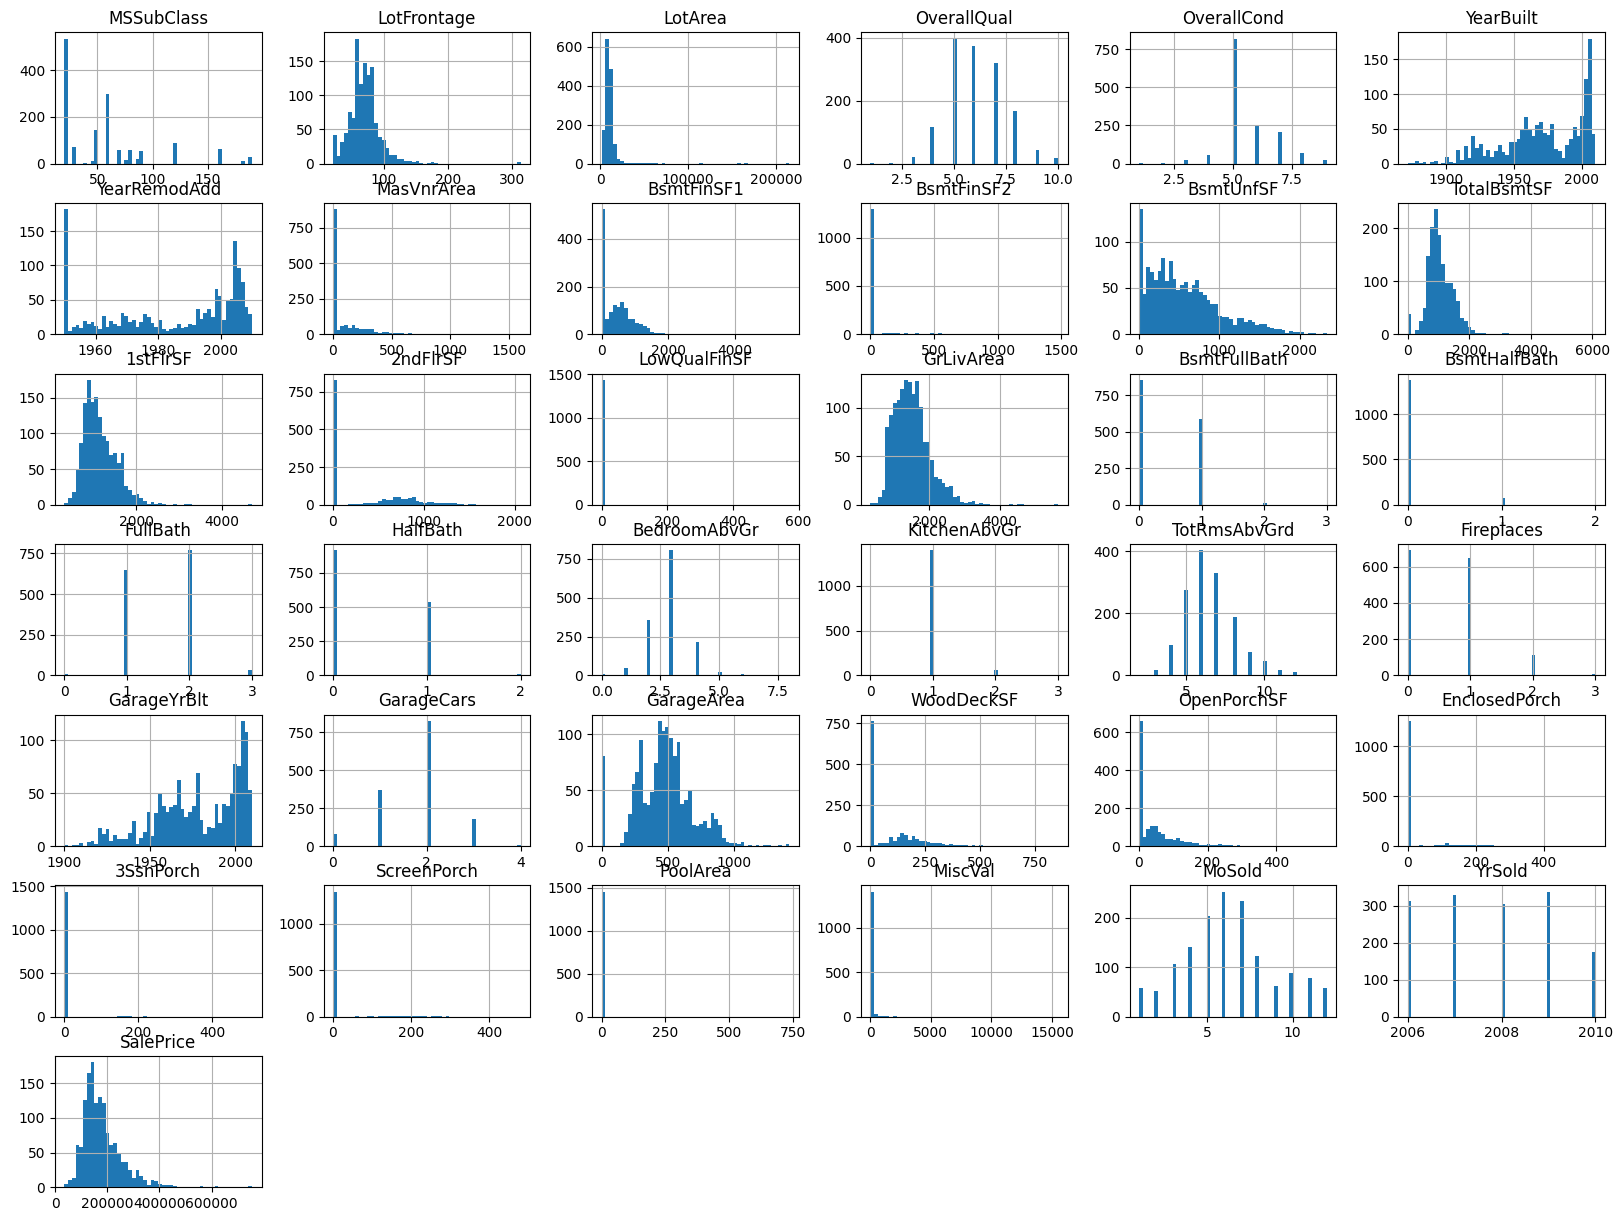

In [5]:
iowa_train_X = val_train.drop('Id', axis=1)

iowa_train_X.hist(bins=50, figsize=(20,15))
plt.show()

In [6]:
iowa_train_X.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
iowa_train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [8]:
# Will provide a dictionary of columns with skewness that are outside the range of 0.4 or -0.4
def calculate_pearsons_skewness(df):
    skew_dict = {}
    
    numeric_colmns = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_colmns:
        if {"mean", "50%", "std"}.issubset(df.index):
            mean = df.loc["mean", col]
            median = df.loc["50%", col]
            std = df.loc["std", col]

            if std != 0:
                skew = (3 * (mean - median)) / std
                if skew >= 0.4 or skew <= -0.4:
                    skew_dict[col] = skew
            else:
                skew_dict[col] = None

    return skew_dict

In [9]:
iowa_train_X_skew = calculate_pearsons_skewness(iowa_train_X.describe())
iowa_train_X_skew

{'MSSubClass': np.float64(0.4891607922962911),
 'OverallCond': np.float64(1.5510679601580728),
 'YearRemodAdd': np.float64(-1.3273044208455576),
 'MasVnrArea': np.float64(1.7179118676357563),
 'BsmtFinSF2': np.float64(0.865661881410468),
 'BsmtUnfSF': np.float64(0.6092812093145498),
 'TotalBsmtSF': np.float64(0.45084557933751646),
 '1stFlrSF': np.float64(0.5868787720375022),
 '2ndFlrSF': np.float64(2.3846725933142054),
 'BsmtFullBath': np.float64(2.4590505229323356),
 'BsmtHalfBath': np.float64(0.7229353995271547),
 'FullBath': np.float64(-2.368410050101725),
 'HalfBath': np.float64(2.28407939497078),
 'BedroomAbvGr': np.float64(-0.49116905558199775),
 'KitchenAbvGr': np.float64(0.6341434595636),
 'TotRmsAbvGrd': np.float64(0.9557223267336468),
 'Fireplaces': np.float64(-1.800867749210217),
 'GarageCars': np.float64(-0.9348536126451287),
 'WoodDeckSF': np.float64(2.2557545978177544),
 'OpenPorchSF': np.float64(0.9807533623195025),
 'EnclosedPorch': np.float64(1.0776054685627696),
 'Scr

In [10]:
from sklearn.model_selection import train_test_split

# Lets split the val_train data into training and validation sets
train_A, test_A = train_test_split(val_train, test_size=0.2, random_state=1)

# Moving forward lets use a copy of train_A to mess with
train_B = train_A.copy().drop('Id', axis=1)

train_B.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
921,90,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,Duplex,1.5Fin,5,7,1900,2003,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1084,Unf,0,188,1272,GasA,Gd,Y,SBrkr,1272,928,0,2200,2,0,2,2,4,2,TA,9,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,70,0,0,0,0,NaN,GdPrv,NaN,0,9,2008,WD,Normal,145900
520,190,RL,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,7,1900,2000,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseA,694,600,0,1294,0,0,2,0,3,2,TA,7,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,220,114,210,0,0,0,NaN,NaN,NaN,0,8,2008,WD,Normal,106250
401,20,RL,65.0,8767,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,24,Unf,0,1286,1310,GasA,Ex,Y,SBrkr,1310,0,0,1310,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2005.0,Fin,2,400,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial,164990
280,60,RL,82.0,11287,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,6,1989,1989,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,Gd,TA,CBlock,Gd,TA,Av,GLQ,421,Unf,0,386,807,GasA,Gd,Y,SBrkr,1175,807,0,1982,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,1989.0,Fin,2,575,TA,TA,Y,0,84,0,196,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,228500
1401,60,RL,62.0,7415,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,TA,TA,No,GLQ,759,Unf,0,80,839,GasA,Ex,Y,SBrkr,864,729,0,1593,1,0,2,1,3,1,TA,8,Typ,1,TA,Attchd,2004.0,Fin,2,398,TA,TA,Y,100,75,0,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Normal,193000


In [11]:
train_B.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,959.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1160.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1107.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.733733,70.210636,10542.357877,6.134418,5.596747,1971.756849,1985.384418,105.122414,452.736301,44.667808,572.617295,1070.021404,1176.254281,340.278253,5.094178,1521.626712,0.437500,0.059075,1.571918,0.380137,2.872432,1.048801,6.548801,0.619863,1978.715447,1.774829,474.120719,94.656678,47.315925,22.753425,3.654110,16.113870,2.418664,49.948630,6.291096,2007.823630,182208.341610
std,42.080779,24.838423,9875.947661,1.369861,1.111237,30.291881,20.587897,178.078113,463.541117,161.909961,448.642738,448.141915,395.462440,434.272050,45.317916,523.534530,0.521547,0.239472,0.546045,0.504665,0.818589,0.219484,1.626478,0.648787,24.977592,0.734614,210.856384,122.161984,67.699475,62.710765,31.103419,57.769137,37.390139,551.953605,2.689124,1.325276,78086.084388
min,20.000000,21.000000,1300.000000,1.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7500.000000,5.000000,5.000000,1954.000000,1968.000000,0.000000,0.000000,0.000000,223.750000,804.000000,888.000000,0.000000,0.000000,1133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,131000.000000
50%,50.000000,69.000000,9501.500000,6.000000,5.000000,1974.000000,1994.000000,0.000000,398.500000,0.000000,484.000000,1007.500000,1098.500000,0.000000,0.000000,1470.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,164945.000000
75%,70.000000,80.000000,11621.750000,7.000000,6.000000,2001.000000,2004.000000,170.250000,728.750000,0.000000,815.250000,1314.500000,1422.000000,728.000000,0.000000,1790.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.500000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,1872.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,2.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [12]:
train_B_nums = train_B.select_dtypes(include=['int64', 'float64'])
train_B_cats = train_B.select_dtypes(include=['object'])

train_B_nums.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
921,90,67.0,8777,5,7,1900,2003,0.0,1084,0,188,1272,1272,928,0,2200,2,0,2,2,4,2,9,0,NaN,0,0,0,70,0,0,0,0,0,9,2008,145900
520,190,60.0,10800,4,7,1900,2000,0.0,0,0,0,0,694,600,0,1294,0,0,2,0,3,2,7,0,NaN,0,0,220,114,210,0,0,0,0,8,2008,106250
401,20,65.0,8767,7,5,2005,2005,0.0,24,0,1286,1310,1310,0,0,1310,0,0,2,0,3,1,6,1,2005.0,2,400,0,0,0,0,0,0,0,7,2006,164990
280,60,82.0,11287,7,6,1989,1989,340.0,421,0,386,807,1175,807,0,1982,0,0,2,1,3,1,7,1,1989.0,2,575,0,84,0,196,0,0,0,1,2007,228500
1401,60,62.0,7415,6,5,2004,2004,0.0,759,0,80,839,864,729,0,1593,1,0,2,1,3,1,8,1,2004.0,2,398,100,75,0,0,0,0,0,4,2008,193000


In [13]:
train_B_cats.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
921,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,Duplex,1.5Fin,Gable,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,NaN,NaN,NaN,NaN,NaN,N,NaN,GdPrv,NaN,WD,Normal
520,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,Gable,CompShg,MetalSd,MetalSd,NaN,TA,TA,BrkTil,NaN,NaN,NaN,NaN,NaN,GasA,TA,N,FuseA,TA,Typ,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,WD,Normal
401,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,New,Partial
280,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,Plywood,Plywood,BrkFace,Gd,TA,CBlock,Gd,TA,Av,GLQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1401,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,NaN,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [14]:
corr_matrix = train_B_nums.corr(numeric_only=True)
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.784018
GrLivArea        0.690093
GarageCars       0.642246
GarageArea       0.626644
TotalBsmtSF      0.602963
1stFlrSF         0.599087
FullBath         0.572780
TotRmsAbvGrd     0.531618
YearBuilt        0.520458
YearRemodAdd     0.510345
GarageYrBlt      0.480070
MasVnrArea       0.474722
Fireplaces       0.454827
BsmtFinSF1       0.373546
LotFrontage      0.315962
WoodDeckSF       0.306120
OpenPorchSF      0.297165
2ndFlrSF         0.287113
LotArea          0.272557
HalfBath         0.256282
BsmtUnfSF        0.217195
BsmtFullBath     0.206739
BedroomAbvGr     0.164527
ScreenPorch      0.126031
MoSold           0.050710
3SsnPorch        0.037551
PoolArea         0.033328
BsmtFinSF2      -0.002371
LowQualFinSF    -0.006937
YrSold          -0.007227
BsmtHalfBath    -0.011842
MiscVal         -0.023378
OverallCond     -0.090111
MSSubClass      -0.097050
EnclosedPorch   -0.121660
KitchenAbvGr    -0.139533
Name: SalePrice, dtype: float64

### Some initial ideas of feature engineering for numeric values:
**MSSubclass can be dropped**, it is in actuality a categorical value in which the data provided can be discerened from other features

We can combine all **porch and wood deck** square footage together as a new feature

We have above ground living area and total basement area  so lets calculate total inside area

Drop 1st, 2nd, and low quality finish square foot features. As well for the different basement square foot features.

Lets also get the total count of full and half baths, independent of whether they are above ground or not.


In [15]:
train_B_nums.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 921 to 1061
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   LotFrontage    959 non-null    float64
 2   LotArea        1168 non-null   int64  
 3   OverallQual    1168 non-null   int64  
 4   OverallCond    1168 non-null   int64  
 5   YearBuilt      1168 non-null   int64  
 6   YearRemodAdd   1168 non-null   int64  
 7   MasVnrArea     1160 non-null   float64
 8   BsmtFinSF1     1168 non-null   int64  
 9   BsmtFinSF2     1168 non-null   int64  
 10  BsmtUnfSF      1168 non-null   int64  
 11  TotalBsmtSF    1168 non-null   int64  
 12  1stFlrSF       1168 non-null   int64  
 13  2ndFlrSF       1168 non-null   int64  
 14  LowQualFinSF   1168 non-null   int64  
 15  GrLivArea      1168 non-null   int64  
 16  BsmtFullBath   1168 non-null   int64  
 17  BsmtHalfBath   1168 non-null   int64  
 18  FullBath   

In [16]:
train_B_nums["TotalPorchSF"] = train_B_nums["OpenPorchSF"] + train_B_nums["EnclosedPorch"] + train_B_nums["3SsnPorch"] + train_B_nums["ScreenPorch"] + train_B_nums["WoodDeckSF"]
train_B_nums["TotalIndoorSF"] = train_B_nums["GrLivArea"] + train_B_nums["TotalBsmtSF"]
train_B_nums["TotalFullBaths"] = train_B_nums["FullBath"] + train_B_nums["BsmtFullBath"]
train_B_nums["TotalHalfBaths"] = train_B_nums["HalfBath"] + train_B_nums["BsmtHalfBath"]

# Lets check the correlation matrix again
corr_matrix = train_B_nums.corr(numeric_only=True)
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice         1.000000
OverallQual       0.784018
TotalIndoorSF     0.761198
GrLivArea         0.690093
GarageCars        0.642246
GarageArea        0.626644
TotalBsmtSF       0.602963
1stFlrSF          0.599087
FullBath          0.572780
TotalFullBaths    0.572023
TotRmsAbvGrd      0.531618
YearBuilt         0.520458
YearRemodAdd      0.510345
GarageYrBlt       0.480070
MasVnrArea        0.474722
Fireplaces        0.454827
TotalPorchSF      0.373691
BsmtFinSF1        0.373546
LotFrontage       0.315962
WoodDeckSF        0.306120
OpenPorchSF       0.297165
2ndFlrSF          0.287113
LotArea           0.272557
HalfBath          0.256282
TotalHalfBaths    0.227860
BsmtUnfSF         0.217195
BsmtFullBath      0.206739
BedroomAbvGr      0.164527
ScreenPorch       0.126031
MoSold            0.050710
3SsnPorch         0.037551
PoolArea          0.033328
BsmtFinSF2       -0.002371
LowQualFinSF     -0.006937
YrSold           -0.007227
BsmtHalfBath     -0.011842
MiscVal          -0.023378
O

In [17]:
train_B_cats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 921 to 1061
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1168 non-null   object
 1   Street         1168 non-null   object
 2   Alley          71 non-null     object
 3   LotShape       1168 non-null   object
 4   LandContour    1168 non-null   object
 5   Utilities      1168 non-null   object
 6   LotConfig      1168 non-null   object
 7   LandSlope      1168 non-null   object
 8   Neighborhood   1168 non-null   object
 9   Condition1     1168 non-null   object
 10  Condition2     1168 non-null   object
 11  BldgType       1168 non-null   object
 12  HouseStyle     1168 non-null   object
 13  RoofStyle      1168 non-null   object
 14  RoofMatl       1168 non-null   object
 15  Exterior1st    1168 non-null   object
 16  Exterior2nd    1168 non-null   object
 17  MasVnrType     482 non-null    object
 18  ExterQual      1168 non-null   

### Notes on categorical features
- Alley needs NA values to fill out missing values
- MsnVnrType needs None values to fill out missing values 
- Bsmt features have NA value for missing ones
- FireplaceQu can have NA values
- Garage features can have NA values
- PoolQC has NA values
- Fence has NA values
- MiscFeatures has NA values

In [18]:
# Knowing some of the transomations we can need to do let us set up the pipeline for this.
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_attributes = train_B_nums.columns.tolist().remove("SalePrice")
cat_attributes = train_B_cats.columns.tolist()

In [20]:
# With the numeric categories lets check the skewness to determine what type of transformation we should do, if any.
skew_dict = calculate_pearsons_skewness(train_B_nums.describe())
skew_dict

{'MSSubClass': np.float64(0.4800576236067954),
 'OverallCond': np.float64(1.6110329964741719),
 'YearRemodAdd': np.float64(-1.2554340050588169),
 'MasVnrArea': np.float64(1.7709489217124716),
 'BsmtFinSF2': np.float64(0.8276416322889134),
 'BsmtUnfSF': np.float64(0.5925692334076021),
 'TotalBsmtSF': np.float64(0.41853753467848676),
 '1stFlrSF': np.float64(0.5898482867748848),
 '2ndFlrSF': np.float64(2.350680319847145),
 'BsmtFullBath': np.float64(2.5165503559504345),
 'BsmtHalfBath': np.float64(0.7400697106962422),
 'FullBath': np.float64(-2.3519054967229436),
 'HalfBath': np.float64(2.259739596522645),
 'BedroomAbvGr': np.float64(-0.46751857608456315),
 'KitchenAbvGr': np.float64(0.6670367420756727),
 'TotRmsAbvGrd': np.float64(1.0122509615471857),
 'Fireplaces': np.float64(-1.757758282642024),
 'GarageCars': np.float64(-0.9195496172857843),
 'WoodDeckSF': np.float64(2.3245368504806123),
 'OpenPorchSF': np.float64(0.9002695258616468),
 'EnclosedPorch': np.float64(1.0884937153767527),


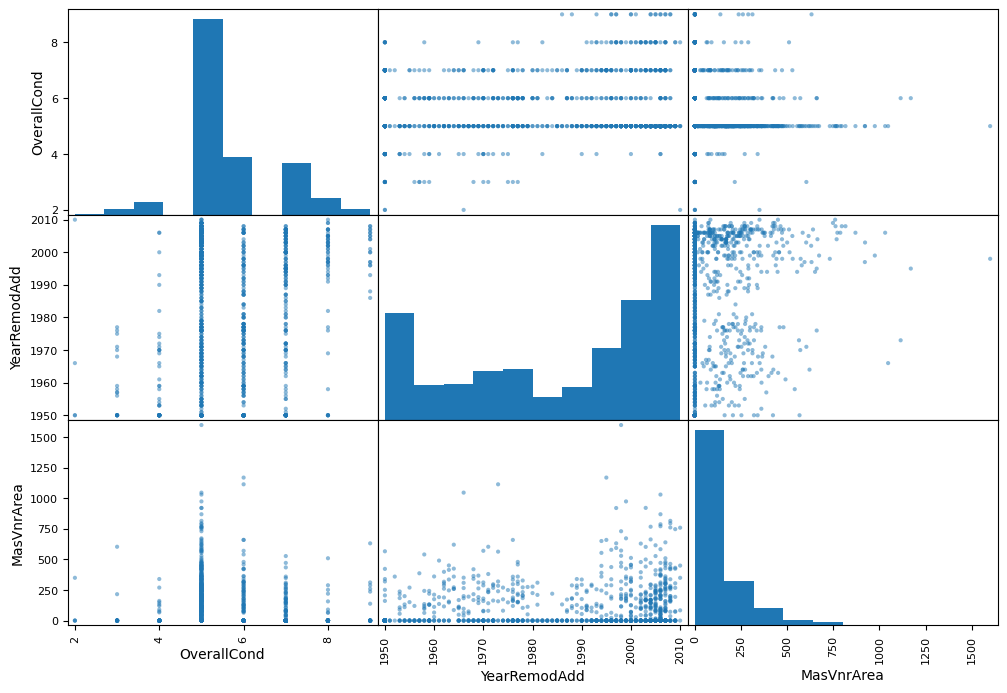

In [23]:
to_check = ["OverallCond", "YearRemodAdd", "MasVnrArea"]
pd.plotting.scatter_matrix(train_B_nums[to_check], figsize=(12, 8))
plt.show()

In [25]:
train_B_nums[to_check].describe()

,OverallCond,YearRemodAdd,MasVnrArea
count,1168.000000,1168.000000,1160.000000
mean,5.596747,1985.384418,105.122414
std,1.111237,20.587897,178.078113
min,2.000000,1950.000000,0.000000
25%,5.000000,1968.000000,0.000000
50%,5.000000,1994.000000,0.000000
75%,6.000000,2004.000000,170.250000
max,9.000000,2010.000000,1600.000000


In [19]:
vnr_imputer = SimpleImputer(strategy="constant", fill_value="None")
gen_cat_imputer = SimpleImputer(strategy="constant", fill_value="NA")

# Fit the imputers on the catergorical features
vnr_imputer.fit(train_B_cats)
gen_cat_imputer.fit(train_B_cats)

# Impute the missing values

SimpleImputer(fill_value='NA', strategy='constant')